<a href="https://colab.research.google.com/github/Paul-mwaura/ML-Hackathons/blob/main/Nairobi_Ambulance_Perambulation_UberKE_with_Gradient_Descent(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

The [Uber Nairobi Ambulance Perambulation Challenge](https://zindi.africa/competitions/uber-nairobi-ambulance-perambulation-challenge) on Zindi is a little different, and you might not have many ideas for how to get started. This is the first of several notebooks I'll be releasing related to the challenge. In this one, we'll use gradient descent to find some locations that reduce our loss - this gives a single set of locations (no changes over time) so it can definitely be improved upon, but it should at least give us a nice baseline which we can attempt to beat :)

Please post questions in the discussion here: https://zindi.africa/competitions/uber-nairobi-ambulance-perambulation-challenge/discussions/3501

# Setup

Upload Train.csv from Zindi and we should be good to go :)

In [ ]:
!pip install --upgrade fastcore -q
!pip install --upgrade fastai -q

In [ ]:
from fastai.vision.all import * # Needs latest version, and sometimes a restart of the runtime after the pip installs

# Loading the Crash Data

In [ ]:
train = pd.read_csv('Train.csv')
train.head()

,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


# Finding locations with Gradient Descent

To do the gradient descent we'll rely on PyTorch to calculate gradients. If you're not familiar with tensors and this part looks scary, check out the fastai lossons that cover SGD from scratch (Lessons 3 and 4 of the new course and this book chapter:https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb). This is where I got a lot of the inspiration for this code.

I start with 6 random locations that are close to the center of the crashes - plot these over the crashes and see if this initialization seems sensible.

In [ ]:
train.describe()

,uid,latitude,longitude
count,6318.000000,6318.000000,6318.000000
mean,3159.500000,-1.270338,36.855459
std,1823.993832,0.125157,0.112866
min,1.000000,-3.050000,36.332202
25%,1580.250000,-1.316585,36.802048
50%,3159.500000,-1.271709,36.844591
75%,4738.750000,-1.233746,36.895642
max,6318.000000,-0.565402,37.879490


#### Check for outliers

 Ourtliers:
 [[-1.6050616087800402, -1.48464840935047, -1.48313562213472, -1.48464840935047, -1.46107358539872, -1.4510349096960602, -1.49122383734707, -1.47924517763491, -1.4740440100626102, -1.5500000088470602, -1.53591625394131, -1.52871904629841, -2.0798751063499, -2.0798751063499, -2.0798751063499, -2.0798751063499, -1.5398883594420505, -2.9255715029212497, -1.4813927229043502, -1.48464840935047, -1.52871904629841, -1.50208187438148, -1.47924517763491, -1.46667000917141, -1.5060095097517698, -1.49122383734707, -1.48410680946995, -2.3948186049724103, -1.49122383734707, -2.66757000345303, -2.66757000345303, -2.66757000345303, -2.0798751063499, -2.66757000345303, -2.66757000345303, -2.0798751063499, -1.50825060203561, -1.45619590963222, -1.49122383734707, -1.50586120930914, -1.50825060203561, -1.50825060203561, -1.52871904629841, -1.52903200916758, -1.51906810903447, -1.51906810903447, -1.46107358539872, -1.95982900730381, -1.4593590950863502, -1.48313562213472, -1.48313562213472, -1

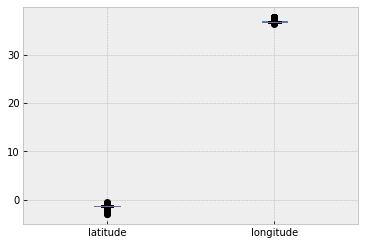

In [ ]:
# Define the numeric columns
#
train[['latitude', 'longitude']]

plt.style.use('bmh')

# Checking for Outliers.
# plotting outliers for the numeric columns
#
_t, cols = pd.DataFrame.boxplot(train[['latitude', 'longitude']], return_type='both')

outliers = [flier.get_ydata() for flier in cols['fliers']]
out_list = [i.tolist() for i in outliers]

print(f" Ourtliers:\n {out_list}")

In [ ]:
# Getting ouliers from our dataframe using a z-test
#
from scipy import stats

z = np.abs(stats.zscore(train[['latitude', 'longitude']]))
print(z)
numeric_df = train[['latitude', 'longitude']]
# Dropping and Confirming that our outliers have been dropped from the dataset.
#
numeric = pd.DataFrame()
numeric[['latitude', 'longitude']] = numeric_df[(z < 3).all(axis=1)]

print(f"Previous dataframe size : {numeric_df.shape[0]}")
print(f"New dataframe size: {numeric.shape[0]}")

[[0.65113548 0.67274607]
 [4.85347917 3.13026793]
 [4.85347917 3.13026793]
 ...
 [0.41368599 0.26769189]
 [0.06593118 0.34504669]
 [0.47014604 0.46232743]]
Previous dataframe size : 6318
New dataframe size: 6194


In [ ]:
train.isna().sum()

uid          0
datetime     0
latitude     0
longitude    0
dtype: int64

In [ ]:
numeric.isna().sum()

latitude     0
longitude    0
dtype: int64

In [ ]:
numeric['datetime'] = train['datetime']

In [ ]:
# Preview the top of the dataset.
#
#train = numeric.copy()
train.head()

,uid,datetime,latitude,longitude
0,1,2018-01-01 00:25:46,-1.188850,36.931382
1,2,2018-01-01 02:02:39,-0.662939,37.208730
2,3,2018-01-01 02:31:49,-0.662939,37.208730
3,4,2018-01-01 03:04:01,-1.288087,36.826583
4,5,2018-01-01 03:58:49,-1.188850,36.931382


In [ ]:
# Ambulance Locations

amb_locs = torch.randn(6, 2) * 0.05 # 6 pairs of random numbers, made fairly small
amb_locs = amb_locs + tensor(-1.271709,	36.844591) # Centered around the middle of town
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
amb_locs # View our set of initial locations

tensor([[-1.3041, 36.8859],
        [-1.3314, 36.8969],
        [-1.3097, 36.7512],
        [-1.1995, 36.7520],
        [-1.2448, 36.8459],
        [-1.2674, 36.8901]], requires_grad=True)

In [ ]:
'''# creating tensor from targets_df 
amb_locs.requires_grad_() # Tell pytorch to calculate gradients
initial_locs = amb_locs.clone() # Save originals for later
# printing out result
print(amb_locs)'''

'# creating tensor from targets_df \namb_locs.requires_grad_() # Tell pytorch to calculate gradients\ninitial_locs = amb_locs.clone() # Save originals for later\n# printing out result\nprint(amb_locs)'

In [ ]:
'''amb_locs = pd.read_csv("cluster_points.csv")
amb_locs.drop(["Unnamed: 0"], axis=1)
amb_locs = torch.tensor(amb_locs[['latitude', 'longitude']].values)
amb_locs.requires_grad_()
amb_locs'''

'amb_locs = pd.read_csv("cluster_points.csv")\namb_locs.drop(["Unnamed: 0"], axis=1)\namb_locs = torch.tensor(amb_locs[[\'latitude\', \'longitude\']].values)\namb_locs.requires_grad_()\namb_locs'

In [ ]:
# Crash locations - turn the training data into a tensor we can work with
crash_locs = tensor(train[['latitude', 'longitude']].values) # To Tensor
crash_locs.shape

torch.Size([6318, 2])

Now we specify our loss function. This needs to preserve gradients, which it does.

In [ ]:
def loss_fn(crash_locs, amb_locs):
  """For each crash we find the dist to the closest ambulance, and return the mean of these dists."""
  # Dists to first ambulance
  dists_split = crash_locs-amb_locs[0]
  dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
  min_dists = dists
  for i in range(1, 6):
    # Update dists so they represent the dist to the closest ambulance
    dists_split = crash_locs-amb_locs[i]
    dists = (dists_split[:,0]**2 + dists_split[:,1]**2)**0.5
    min_dists += torch.min(min_dists, dists)
  
  return min_dists.min()

In [ ]:
# Calculate loss:
loss = loss_fn(crash_locs, amb_locs)
loss

tensor(0.0768, grad_fn=<MinBackward1>)

In [ ]:
# We can use .backward to find gradients
loss.backward()

RuntimeError: ignored

In [ ]:
# View gradients - they've been calculated for us!!!
amb_locs.grad

These gradients tell us which way to move the locations to reduce the loss. This is all we need to do some gradient descent! We'll pick a learning rate, and then run through 1500 steps, updating the locations each time:

In [ ]:
amb_locs.grad = None # Reset gradients
lr=0.001 # Pick LR
for i in range(1000):
  loss = loss_fn(crash_locs, amb_locs) # Find loss
  if i % 100 == 0: print('Loss:', loss.item()) # Print loss
  #loss.backward() # Calc grads
  amb_locs.data -= lr * amb_locs.grad.data # Update locs
  amb_locs.grad = None # Reset gradients for next step

Loss: 0.08042207360267639


AttributeError: ignored

In [ ]:
# Plot crashes and ambulance locations
ax = train.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), c="gold", label='crash locations')
ax.scatter(initial_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='red', label='initial ambulance locs')
ax.scatter(amb_locs[:,1].detach().numpy(), amb_locs[:,0].detach().numpy(), c='green', label='final ambulance locs')
ax.legend()

# Stochastic Gradient Descent and a Validation Set

We can train with mini-batches (SGD) to speed things up. We'll also use the last 1000 crashes as a validation set and track how well we do on that over time. 

In [ ]:
# Split for validation
train_locs = crash_locs[:-1400]
val_locs = crash_locs[-1400:]

# Load crash locs from train into a dataloader
dl = DataLoader(train_locs, batch_size=50, shuffle=True)

# Set vars
lr=0.04
n_epochs = 1000

# Store loss over time
train_losses = []
val_losses = []

# Training loop
for epoch in range(n_epochs):
   # Run through batches
  for crashes in dl:
    loss = loss_fn(crashes, amb_locs) # Find loss for this batch of crashes
    loss.backward() # Calc grads
    amb_locs.data -= lr * amb_locs.grad.data # Update locs
    amb_locs.grad = None # Reset gradients for next step
    train_losses.append(loss.item())
    val_losses.append(loss_fn(val_locs, amb_locs).item()) # Can remove as this lows things down

  # Print validation loss
  print('Val loss:', loss_fn(val_locs, amb_locs).item())

RuntimeError: ignored

In [ ]:
plt.figure(num=None, figsize=(10, 10), dpi=50, facecolor='w', edgecolor='k')
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, c='red', label='val loss')
plt.legend()

In [ ]:
amb_locs

In [ ]:
amb = pd.DataFrame(amb_locs)
amb.columns = ['latitude', 'longitude']
amb

In [ ]:
def score(sub, ref):
    total_distance = 0
    for date, c_lat, c_lon in ref[['datetime', 'latitude', 'longitude']].values:
        row = sub.loc[sub.date < date].tail(1) # Prior to Oct 2 this was incorrectly .head(1)
        dists = []
        for a in range(1,6):
            dist = ((c_lat - row[f'A{a}_Latitude'].values[0])**2+(c_lon - row[f'A{a}_Longitude'].values[0])**2)**0.5 
            dists.append(dist)
            
        total_distance = min(dists)
    return total_distance

In [ ]:
val_locs.numpy()

array([[-1.2698303, 36.80743  ],
       [-1.2257562, 36.88497  ],
       [-1.3321493, 36.889168 ],
       ...,
       [-1.3221091, 36.82525  ],
       [-1.2785887, 36.816517 ],
       [-1.2115002, 36.907635 ]], dtype=float32)

In [ ]:
# Test set
reference = train.loc[train.datetime > '2019-01-01'] # Using 2019 as our test set
reference.head(2)

,uid,datetime,latitude,longitude
4396,4397,2019-01-01 11:16:39,-1.298568,36.806244
4397,4398,2019-01-01 13:29:39,-1.316169,36.895726


In [ ]:
# Date rane covering test set
dates = pd.date_range('2019-01-01', '2020-01-01', freq='3h')

# Create submission dataframe
sub = pd.DataFrame({
    'date':dates
})

for ambulance in range(6):
  sub['A'+str(ambulance)+'_Latitude'] = amb.latitude[ambulance]
  sub['A'+str(ambulance)+'_Longitude'] = amb.longitude[ambulance]

score(sub, reference)

0.017348537625199337

In [ ]:
# Export Submission File.
sub.to_csv("submission_sgd.csv")


### Load the Submission file

In [ ]:
sub = pd.read_csv("submission.csv")
sub.head()

FileNotFoundError: ignored

# Animation version

I used this to visualize how the locations change over time - Not necessary at all but I thought it was quite fun to watch :)

In [ ]:
cs = pd.read_csv('Train.csv')
# Clipping to the central area for a better view
cs = cs.loc[(cs.latitude < -1.375+0.2)&(cs.latitude > -1.375)\
            &(cs.longitude > 36.6)&(cs.longitude < 36.6+0.45)]
crash_locs = tensor(cs[['latitude', 'longitude']].values) # To Tensor

In [ ]:
locs = []
# Ambulance Locations
amb_locs = torch.randn(6, 2) * 0.04
amb_locs = amb_locs + tensor(-1.27, 36.85)
amb_locs.requires_grad_()
locs.append(amb_locs.detach().numpy()) # Store

In [ ]:
lr=1e-2 # Pick LR
for i in range(200):
  loss = loss_fn(crash_locs, amb_locs) # Find loss
  if i % 100 == 0: print('Loss:', loss.item()) # Print loss
  loss.backward() # Calc grads
  amb_locs.data -= lr * amb_locs.grad.data # Update locs
  locs.append(locs[-1] - lr*amb_locs.grad.data.numpy() ) # Store locs
  amb_locs.grad = None # Reset gradients for next step

Loss: 0.05449259653687477
Loss: 0.026169080287218094


In [ ]:
!rm -r ims
!mkdir ims
for i in range(200):
  ax = cs.plot(y='latitude', x='longitude', kind='scatter', figsize=(16, 10), label='crash locations')
  ax.scatter(locs[i][:,1], locs[i][:,0], c='red', label=f'ambulance locs at {i}')
  ax.legend()
  plt.savefig(f'ims/{str(i).zfill(3)}.png')
  plt.clf()
  plt.close()

rm: cannot remove 'ims': No such file or directory


In [ ]:
!ffmpeg -framerate 8 -pattern_type glob -i 'ims/*.png' \
  -c:v libx264 -r 30 -pix_fmt yuv420p out.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib